# Workshop on explainable AI - Hands-on part 
In this hands on session we will focus on a multiclass classification task. We will start from a model that predicts the price category of different phones, and we will try to:
* Explain how each feature contributes to te model
* Explain different individual predictions

---
# Import data

In [1]:
import pandas as pd
import numpy as np

path_data = "../data/"

In [2]:
df = pd.read_csv(path_data + "phones_data_prepared.csv", index_col="model_name")
df.head()

,brand_name,os,popularity,sellers_amount,screen_size,memory_size,battery_size,release_year,price_range
model_name,,,,,,,,,
1 1/8GB Bluish Black (5033D-2JALUAA),other,Android,422,36,5.00,8.0,2000.0,2020,low
1 5033D 1/16GB Volcano Black (5033D-2LALUAF),other,Android,323,36,5.00,16.0,2000.0,2020,low
1.3 1/16GB Charcoal,other,Android,1047,10,5.71,16.0,3000.0,2020,low
10 6/64GB Black,other,Android,71,2,5.80,64.0,3400.0,2018,high
10 Lite 3/32GB Blue,other,Android,424,2,6.21,32.0,3400.0,2018,medium-low


In [3]:
df.shape

(1068, 9)

In [4]:
df["price_range"].value_counts()

low            267
high           267
medium-low     267
medium-high    267
Name: price_range, dtype: int64

---
# Preprocess
The dataset is already preprocessed, here we just do a one-hot encoding of the categorical predictors.

In [5]:
df = pd.get_dummies(df, columns=["brand_name", "os"])

---
# Classification model
Train a quick model so to dive into explainability right away. Needless t say, model training outside the context of this workshop sholud receive much more love :)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["price_range"]),
    df["price_range"],
    train_size=0.8,
    random_state=0,
)

In [8]:
clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=10, max_depth=10)
clf.fit(X_train, y_train)

print("Training set score (mean accuracy): {:.4f}".format(clf.score(X_train, y_train)))
print("Test set score (mean accuracy): {:.4f}".format(clf.score(X_test, y_test)))

Training set score (mean accuracy): 0.8080
Test set score (mean accuracy): 0.7383


---
---
# Explainable AI
Explainability was a hot topic long before LIME, SHAP, etc. Let's quickly look at some of the old strategies before diving hands-on in the recent developments.

Decision trees and linear models have always been the go-to algorithms for interpretability.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

sns.set_style("whitegrid")
sns.set()

In [10]:
# For convenience, we will need this list throught the notebook
feature_names = list(X_train.columns)

### Visual interpretation

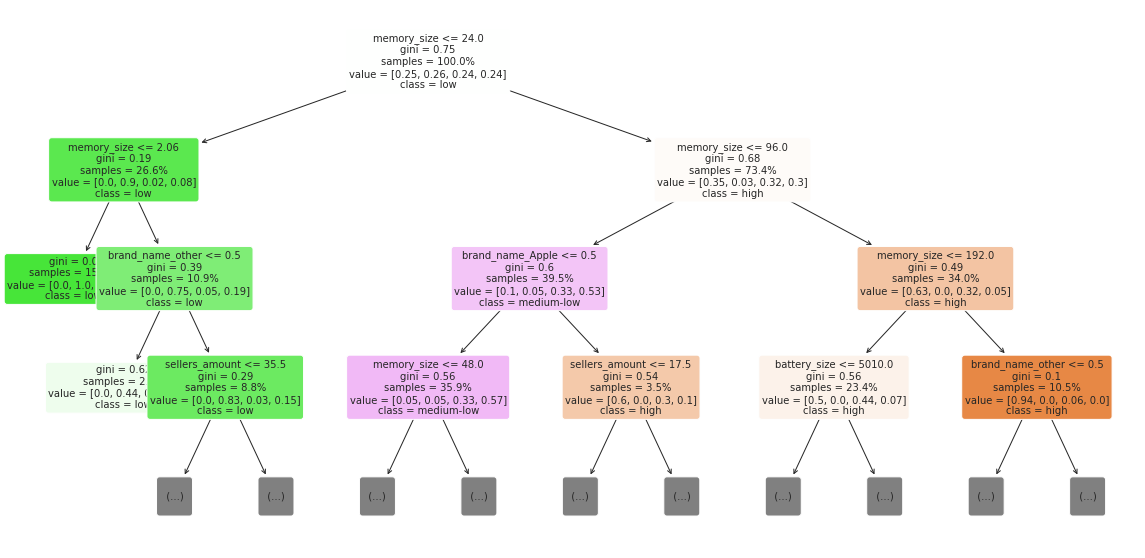

In [11]:
f, a = plt.subplots(figsize=(20, 10))
tree.plot_tree(
    clf,
    max_depth=3,
    fontsize=10,
    feature_names=feature_names,
    class_names=clf.classes_,
    filled=True,
    proportion=True,
    precision=2,
    rounded=True,
    ax=a,
);

### Feature "importance"
The "importance" of each feature (a better name is perhaps "participation") is also a quantitative attempt at explaining the model. 

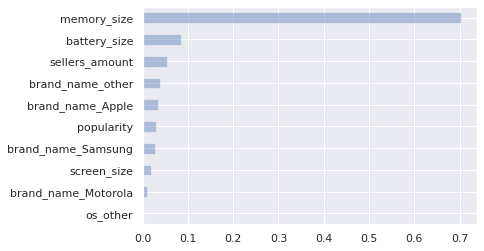

In [12]:
mean_importances = clf.feature_importances_
pd.Series(mean_importances, index=feature_names).sort_values()[-10:].plot.barh(
    alpha=0.4
);

For sklearn trees importance is computed based on the decrease in node impurity (see eg https://datascience.stackexchange.com/a/66372/134365). 

However, feature importance gives different insights depending on how it is computed. More recent libraries implement different approaches for computing feature importance, we use here lighgbm to illustrate how this can become confusing.

In [13]:
import lightgbm as lgb

clf_lgb = lgb.LGBMClassifier(max_depth=5, n_estimators=10, random_state=0)
clf_lgb.fit(X_train, y_train, eval_metric="logloss")

print(
    "Training set score (mean accuracy): {:.4f}".format(clf_lgb.score(X_train, y_train))
)
print("Test set score (mean accuracy): {:.4f}".format(clf_lgb.score(X_test, y_test)))

Training set score (mean accuracy): 0.7951
Test set score (mean accuracy): 0.7056


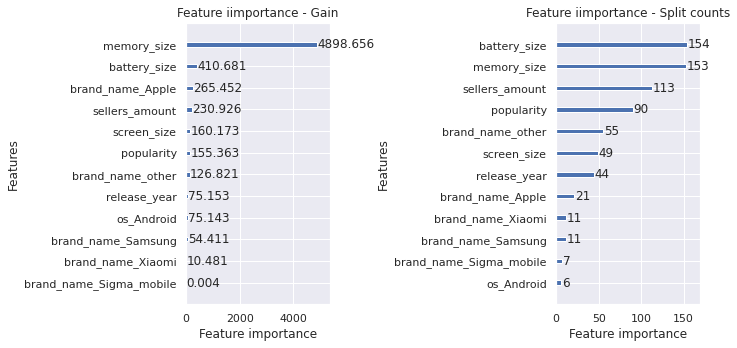

In [14]:
f, a = plt.subplots(1, 2, figsize=(10, 5))
lgb.plot_importance(
    clf_lgb,
    importance_type="gain",
    ax=a[0],
    title="Feature iimportance - Gain",
)
lgb.plot_importance(
    clf_lgb,
    importance_type="split",
    ax=a[1],
    title="Feature iimportance - Split counts",
)
plt.tight_layout()

---
---
# Hands-on time
Tree visualization, feature importances, linear coeffcients and similars, while very useful, have obvius drawbacks (not model agnostic, possibly contradictory, tells us little about individual predictions). Hence the need for new XAI tools to extract more reliable model explanations.

In this hands-on exercise we use an XAI tool to:
1. Explain the overall impact of the different features
2. Explain the prediction for an iPhone 12
    * Which features seem to justify the prediction?
    * Which features seem instead less in line with the prediction?
    * What are other reasonable predictions, if any? Why?
    
**Your task**: pick one (ore more) of the tools from the 3 listed below, and try to answer the above questions. Pick eli5 if you want to see something not covered in the theoretical part (some theoretical pointers in the cells below).
1. Eli5
2. SHAP
3. Lime

In [15]:
# Phone model under investigation
phone_model = "iPhone 12 64GB Dual Sim (PRODUCT)RED (MGGP3)"

feature_vector = X_test.loc[[phone_model]]
feature_vector.T

model_name,iPhone 12 64GB Dual Sim (PRODUCT)RED (MGGP3)
popularity,987.0
sellers_amount,40.0
screen_size,6.1
memory_size,64.0
battery_size,2815.0
release_year,2020.0
brand_name_Apple,1.0
brand_name_Motorola,0.0
brand_name_Samsung,0.0
brand_name_Sigma mobile,0.0


In [16]:
# Predicted price range
phone_model_prediction = clf.predict(feature_vector)
phone_model_prediction

array(['high'], dtype=object)

<br>

---
# 1. Eli5 
A python package to explain predictions for tabular, image and text data (general idea described here: http://blog.datadive.net/interpreting-random-forests/)

Hints:
* Explain features overall impact: https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights
* Explain predictions: https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_prediction
* Set IDE theme to light since Eli5 uses some html formatting

In [17]:
import eli5

<br>

## 1.1. Explain overall impact of features

In [18]:
eli5.show_weights(
    clf,
    top=5,
    feature_names=feature_names,
    target_names=list(clf.classes_),
    targets=list(clf.classes_),
    show=["feature_importances", "description", "targets"],
)  # ‘gain’, ’weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’)

<br>

## 1.2. Explain individual predictions

In [19]:
explaination = eli5.show_prediction(
    clf,
    feature_vector,
    feature_names=feature_names,
    top_targets=4,
    show_feature_values=True,
)
explaination

<br>

---
# 2. SHAP
Hints:
* Remeber that shap explanations are computed starting from the trained model and some data (image below)
* Explain features overall impact: Make sure that the order for class names in shap and in the classifier is consistent.
* Explain predictions: if using a waterfall plot, be aware of this issue: https://github.com/slundberg/shap/issues/1420

<br>

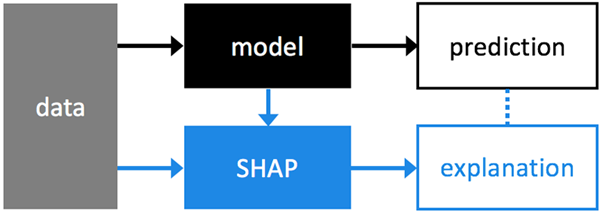


In [20]:
import shap

In [21]:
shap.initjs()

In [22]:
# First of all, let's build the explainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

In [23]:
# Note that shap_values is a list with 1 element per class
type(shap_values), len(shap_values)

(list, 4)

In [24]:
# Each element of the list is a 2D array: N_instances x M_features
print(shap_values[0].shape)

(854, 16)


<br>

## 2.1. Explain overall impact of features

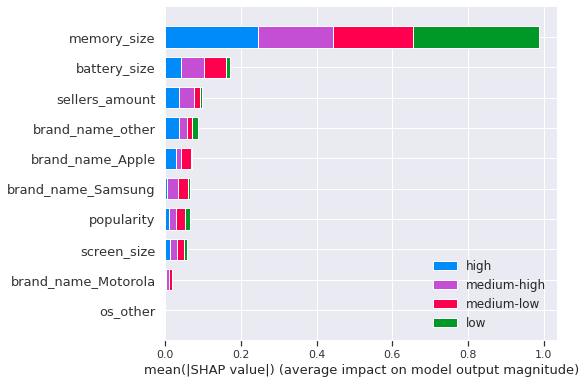

In [25]:
# Show average shap value per class
shap.summary_plot(
    shap_values, X_train, class_names=clf.classes_, plot_type="bar", max_display=10
)

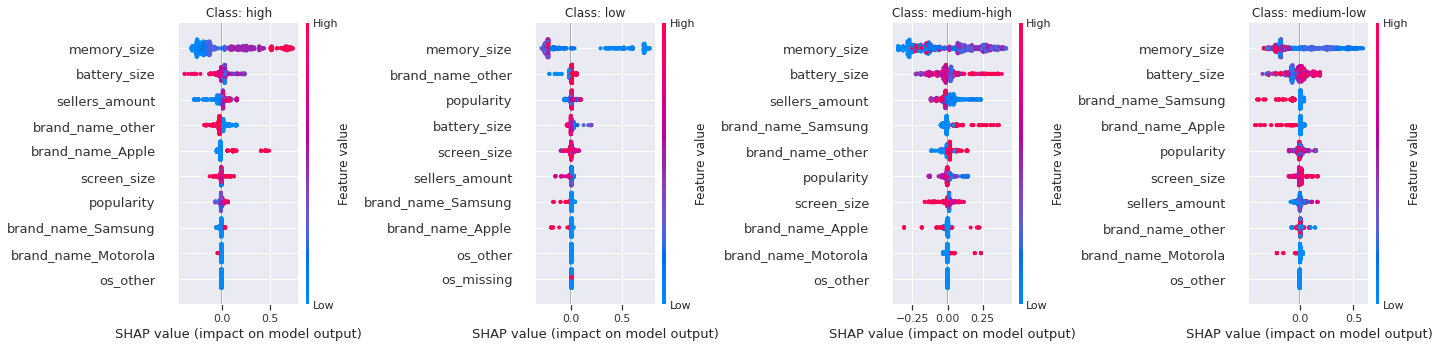

In [26]:
# Show shap value for each class, feature, instance. This is a high level view with an instance-level granularity - very informative!
for i, c in enumerate(clf.classes_):
    plt.subplot(1, 4, i + 1)
    shap.summary_plot(
        shap_values[i],
        X_train,
        max_display=10,
        show=False,
        plot_size=(20, 5),
    )
    plt.title("Class: " + c)
plt.tight_layout()

<br>

## 2.2. Explain individual prediction 

In [27]:
# Compute shap values just for the prediction under investigation (alternatively, retrieve it form the shap values computed above)
phone_model_shap_values = explainer.shap_values(feature_vector)

print(type(phone_model_shap_values), len(phone_model_shap_values))
print(phone_model_shap_values[0].shape)

<class 'list'> 4
(1, 16)


In [28]:
# Remember that shap_values() returns a list with 1 element per class. Here we need to know the index of the prediced class to find the shap values of our prediction
idx_predicted_class = np.argmax(clf.predict_proba(feature_vector))
idx_predicted_class

0

#### Waterfall plot
Show feature importance for an individual prediction, with corresponding feature values.

The ShapInput class is a workaround to a known issue ofthe current Shap relaese

Predicted price range:  ['high']


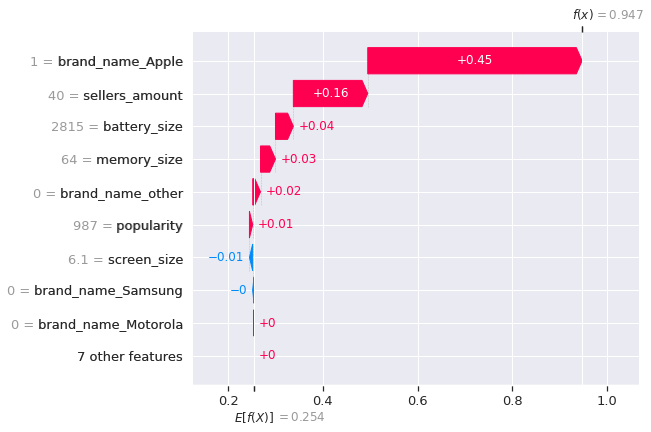

In [29]:
class ShapInput(object):
    def __init__(self, expectation, shap_values, features, feat_names):
        self.base_values = expectation
        self.values = shap_values
        self.data = features
        self.feature_names = feature_names
        self.display_data = None


shap_input = ShapInput(
    explainer.expected_value[idx_predicted_class],
    phone_model_shap_values[idx_predicted_class][0, :],
    # turned into a Series for cmpatibility with waterfall_plot()
    feature_vector.iloc[0],  
    feature_names,
)

print("Predicted price range: ", phone_model_prediction)
shap.waterfall_plot(shap_input)

#### Force plot
Force plots are less readable, but have the advantage that we can stack multiple individual predictions

In [30]:
shap.plots.force(
    explainer.expected_value[idx_predicted_class],
    phone_model_shap_values[idx_predicted_class][0, :],
    features=feature_vector,
    out_names=list(clf.classes_),
)

In [31]:
# stacking force plots to get another high-level explanation
shap.plots.force(
    explainer.expected_value[idx_predicted_class],
    shap_values[idx_predicted_class],
    features=X_train,
    out_names=list(clf.classes_),
)

<br>

---
# 3. LIME

Hints: 
* Explain features overall impact
* Explain prediction: https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular



In [32]:
import lime

In [33]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=clf.classes_,
)

<br>

## 3.1. Explain overall impact of features
I am actually not sure LIME provides anything original for this. We will have to rely on previously seen options


<br>

## 3.2. Explain individual prediction

In [34]:
# We now explain a single instance:

exp = lime_explainer.explain_instance(
    # note we need to pass a 1D array
    np.array(feature_vector).reshape(-1),  
    clf.predict_proba,
    top_labels=1,
)

exp.show_in_notebook(show_table=True, show_all=False)

---
---
# COMPARE
Before concluding, it is interesting to compare algorithms on a batch of instances to see if they "agree" on what the key features are in each individual prediction. The code below makes predction on ~200 instances and makes frequency plots for the 1st, 2nd, and 3rd key predictor.

Also note that only SHAP can, to the best of my knowledge, make a vectorized predictor. This is often a key advantage in practice.

In [35]:
from tqdm import tqdm

In [36]:
# Only focus on first 3 key predictors
top_N = 3

### Eli5

In [37]:
# Highlight key features for each instance (excpet for the BIAS)
l = []
for i in tqdm(range(X_test.shape[0])):
    top_features = list(
        eli5.formatters.as_dataframe.explain_prediction_df(
            clf,
            X_test.iloc[[i]],
            top_targets=1,
            top=top_N + 1,
            feature_names=feature_names,
        )["feature"]
    )
    top_features.remove("<BIAS>")
    l.append(top_features[:top_N])

100%|██████████| 214/214 [00:01<00:00, 133.44it/s]


In [38]:
# Store results in a dataset
df_eli5 = pd.DataFrame(l)
df_eli5["explainer"] = "eli5"

### Shap

In [39]:
# build the explainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

In [40]:
# Highlight key features for each instance

# Note that shap returns shapely values for all classes, but we only care about our prediciton
# Therefore we create a 2d array where each row correspond to a prediction, and the values in the row are the shapely values associated to that prediction
dict_classes = {c: i for i, c in enumerate(clf.classes_)}
shap_values_of_predicted_class = [
    shap_values[dict_classes[c]][i, :] for i, c in enumerate(clf.predict(X_test))
]

# Now only take the first N key features
key_features = np.take(
    np.flip(np.argsort(shap_values_of_predicted_class, axis=1), axis=1),
    range(top_N),
    axis=1,
)

In [41]:
# Store results in a dataset
feature_map = {i: c for i, c in enumerate(X_test.columns)}
df_shap = pd.DataFrame(key_features)
for c in df_shap.columns:
    df_shap[c] = df_shap[c].map(feature_map)
df_shap["explainer"] = "shap"

### Lime
Note that with Lime this works particularly poorely. One trick to improve speed is to reduce the num_samples argument (https://github.com/marcotcr/lime/issues/213)    

In [42]:
# Highlight key features for each instance

l = []
for i in tqdm(range(X_test.shape[0])):
    exp = lime_explainer.explain_instance(
        X_test.values[i],
        clf.predict_proba,
        num_features=top_N,
        num_samples=1000,
    )
    l.append(exp.as_list())

100%|██████████| 214/214 [04:22<00:00,  1.23s/it]


In [43]:
# Store results in a dataset

# Note that lime has no clean way of returning the list of key features.
# here we do a small workaround, migt not work on different feature names.
df_lime = pd.DataFrame(l)
for c in df_lime.columns:
    df_lime[c] = (
        df_lime[c].astype(str).str.replace("\d|<|>|=|'|-|,|\(|\)|\.", "", regex=True)
    )
    df_lime[c] = df_lime[c].str.strip()
df_lime["explainer"] = "lime"

## Plot results

In [44]:
df_plot = pd.concat([df_lime, df_eli5, df_shap]).reset_index(drop=True)
df_plot.columns = ["feature_0", "feature_1", "feature_2", "explainer"]

for i in range(top_N):
    df_plot.rename(columns={i: "feature_" + str(i)}, inplace=True)

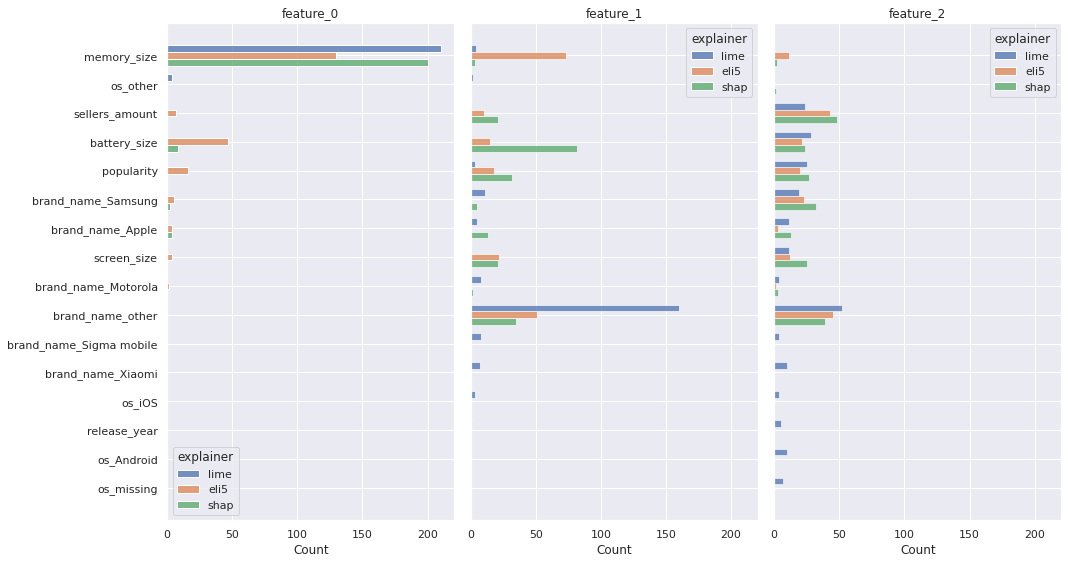

In [45]:
f, a = plt.subplots(1, top_N, figsize=(15, 8), sharex=True, sharey=True)

# show proportion of features
for i in range(top_N):
    sns.histplot(
        data=df_plot,
        y="feature_" + str(i),
        hue="explainer",
        multiple="dodge",
        shrink=0.7,
        ax=a[i],
    )
    a[i].set(title="feature_" + str(i), ylabel="")
plt.tight_layout()